# Modelos Prophet


## Preparación

In [1]:
#!pip install prophet

In [2]:
import pandas as pd
from prophet import Prophet
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
import numpy as np

In [3]:
data = pd.read_csv("basedatosmapper(624).csv")
data.drop(columns = ["Unnamed: 0"], inplace = True)
data.head()

,consumo_laminados_guatemala,prod_laminados_cuba,consumo_largos_república_dominicana,consumo_laminados_chile,impo_laminados_el_salvador,PRECIO_TERMINADOS_platePlacaDeHoja,precio_Chicago - Shredded Auto,prod_laminados_brasil,consumo_tubos sin costura_ecuador,consumo_laminados_argentina,impo_laminados_honduras,consumo_laminados_venezuela,CNA_Planchón,CNA_PLANOS,Fecha
0,70.643713,9.18,36.630,240.987028,41.860124,36.0625,325.0,1923.0,3.805159,420.278833,32.138228,14.227417,346817.522040,1.334947e+06,2018-01
1,55.088375,8.16,38.850,221.626794,17.001200,40.2500,325.0,1861.0,3.156326,473.079833,30.200615,23.328515,280760.102470,1.236832e+06,2018-02
2,65.905957,7.14,39.960,234.598777,33.104572,45.2000,360.0,2130.0,8.100546,447.157833,38.245553,24.711448,296948.464300,1.432077e+06,2018-03
3,66.458827,9.18,37.185,225.024612,47.871124,47.0000,380.0,2038.0,11.873831,472.878833,26.215781,21.273352,336959.515894,1.404093e+06,2018-04
4,78.032696,9.18,35.520,238.383707,33.664367,46.3125,370.0,2026.0,15.140181,459.077833,30.784989,15.167425,387738.621924,1.389706e+06,2018-05


In [4]:
data.rename(columns={'Fecha': 'ds', 'CNA_PLANOS': 'y'}, inplace= True)
data['ds'] = pd.to_datetime(data['ds'])

## Prophet con Variables Mapper

In [5]:
data2 = data.copy()

# Escalar los regresores (excluyendo Fecha y CNA_PLANOS)

train_indices = slice(25, 66)  # entrenamiento
test_indices = slice(66, 72)   # prueba

train_raw = data.iloc[train_indices].copy()
test_raw = data.iloc[test_indices].copy()

# Escalar solo con datos de entrenamiento

regressor_names = data2.drop(columns=["ds", "y"]).columns
regressor_notscaled = data2.drop(columns=["ds","y"])
scaler = StandardScaler()
scaler.fit(train_raw[regressor_names])
scaled_regressors = scaler.transform(data2[regressor_names])
scaled_regressors_df = pd.DataFrame(scaled_regressors, columns=regressor_names)

# Construir df_prophet con regresores escalados
df_prophet = pd.concat([data2[['ds', 'y']].reset_index(drop=True), scaled_regressors_df], axis=1)

# Dividir en train y test
train = df_prophet.iloc[train_indices].copy()
test = df_prophet.iloc[test_indices].copy()

# Crear y ajustar el modelo Prophet con regresores
model = Prophet()
for reg in regressor_names:
    model.add_regressor(reg)

model.fit(train)

# Crear fechas futuras
future = model.make_future_dataframe(periods=7, freq='M')

# Asignar regresores escalados para fechas de entrenamiento
future = future.merge(
    df_prophet[['ds'] + list(regressor_names)],
    on='ds',
    how='left'
)

# Para las fechas futuras (NaN en regresores), poner ceros
future[regressor_names] = future[regressor_names].fillna(0)

# Ahora predecir con future que tiene regresores reales en train y 0 en futuro
forecast = model.predict(future)


INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxila1ara/t5ox_0nn.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxila1ara/_ot9q5ug.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=41669', 'data', 'file=/tmp/tmpxila1ara/t5ox_0nn.json', 'init=/tmp/tmpxila1ara/_ot9q5ug.json', 'output', 'file=/tmp/tmpxila1ara/prophet_modelxatst074/prophet_model-20250610045530.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:55:30 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:55:30 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing
/usr/local/lib/python3.11/dist-packages

In [6]:
# Alinear fechas de x_test al final de cada mes
x_test_aligned = test_raw.copy()
x_test_aligned['ds'] = pd.to_datetime(x_test_aligned['ds']) + pd.offsets.MonthEnd(0)

# Seleccionar solo columnas de interés en forecast
forecast_relevant = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

# Hacer merge por fecha
comparison = pd.merge(x_test_aligned, forecast_relevant, on='ds', how='left')

# Revisar los resultados
print(comparison.tail(6))

   consumo_laminados_guatemala  prod_laminados_cuba  \
0                    96.813322             8.865661   
1                   103.381643             8.865661   
2                   102.009519             7.253722   
3                   133.282645             8.059692   
4                    80.507705             8.865661   
5                   106.903969             8.865661   

   consumo_largos_república_dominicana  consumo_laminados_chile  \
0                            40.054659               215.259092   
1                            40.443267               198.542049   
2                            38.245783               203.302206   
3                            37.157469               153.022535   
4                            39.340565               217.982904   
5                            34.970627               176.711621   

   impo_laminados_el_salvador  PRECIO_TERMINADOS_platePlacaDeHoja  \
0                   42.487790                              75.000   
1     

In [7]:
# Cálculo de métricas con datos válidos
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat']) * 100

In [8]:
print("MÉTRICAS DE EVALUACIÓN")
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.2f}%")
print(f"Precisión: {100-mape:.2f}%")

MÉTRICAS DE EVALUACIÓN
MAE:  67,494
RMSE: 75,495
MAPE: 4.35%
Precisión: 95.65%


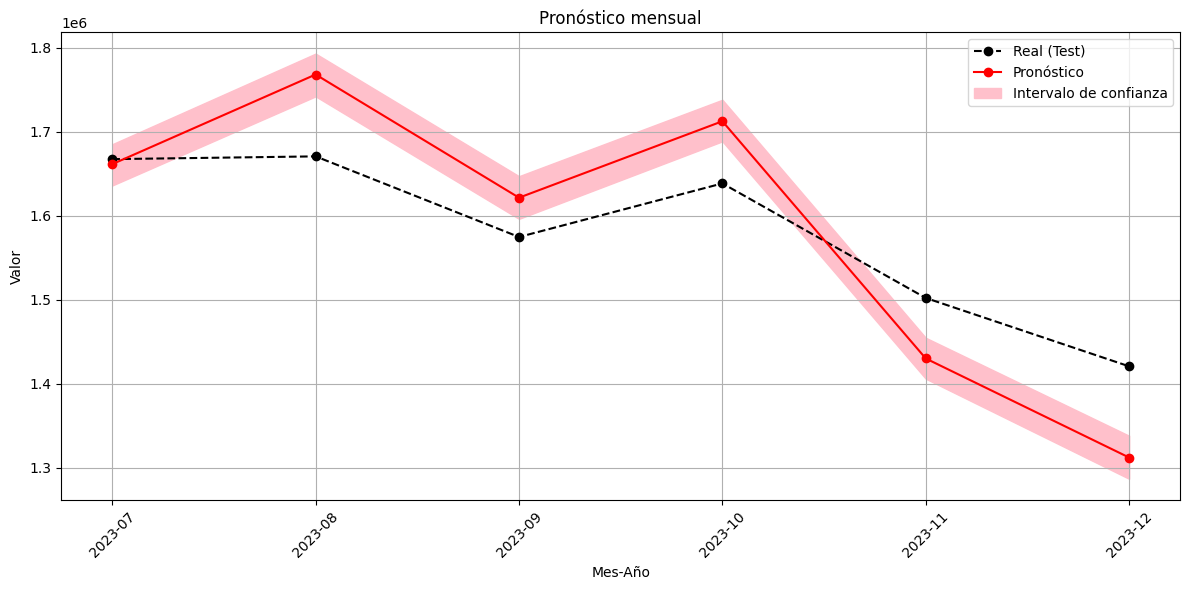

In [9]:
import matplotlib.pyplot as plt

test_raw['mes_año'] = test_raw['ds'].dt.to_period('M').astype(str)
forecast['mes_año'] = forecast['ds'].dt.to_period('M').astype(str)

forecast_filtered = forecast[['mes_año', 'yhat', 'yhat_lower', 'yhat_upper']].drop_duplicates(subset='mes_año')
comparison = pd.merge(test_raw[['mes_año', 'y']], forecast_filtered, on='mes_año', how='left')

plt.figure(figsize=(12, 6))
# Datos reales
plt.plot(comparison['mes_año'], comparison['y'], label='Real (Test)', color='black', linestyle='--', marker='o')
# Predicción
plt.plot(comparison['mes_año'], comparison['yhat'], label='Pronóstico', color='red', marker='o')
#Intervalos de Confianza
plt.fill_between(comparison['mes_año'], comparison['yhat_lower'], comparison['yhat_upper'], color='pink', alpha=1, label='Intervalo de confianza')

plt.xlabel("Mes-Año")
plt.ylabel("Valor")
plt.title("Pronóstico mensual")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

## Predicción solo con variable objetivo

In [10]:
data3 = data.copy()
x_train = data3[["ds","y"]].iloc[0:66]
x_test = data3[["ds","y"]].iloc[66:72]

model = Prophet()
model.fit(x_train)

future = model.make_future_dataframe(periods=7, freq='M')

forecast = model.predict(future)
forecast_last_6 = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']].tail(6)
print(forecast_last_6)

INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxila1ara/0_gs1862.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpxila1ara/dah6b6zp.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=93338', 'data', 'file=/tmp/tmpxila1ara/0_gs1862.json', 'init=/tmp/tmpxila1ara/dah6b6zp.json', 'output', 'file=/tmp/tmpxila1ara/prophet_models2n730b_/prophet_model-20250610045912.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
04:59:12 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
04:59:12 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


           ds          yhat    yhat_lower    yhat_upper
67 2023-07-31  1.503700e+06  1.375863e+06  1.631245e+06
68 2023-08-31  1.152120e+06  1.018333e+06  1.298041e+06
69 2023-09-30  1.436939e+06  1.310362e+06  1.572203e+06
70 2023-10-31  1.285252e+06  1.152004e+06  1.413337e+06
71 2023-11-30  1.446094e+06  1.311815e+06  1.581956e+06
72 2023-12-31  1.662883e+06  1.528560e+06  1.795319e+06


/usr/local/lib/python3.11/dist-packages/prophet/forecaster.py:1872: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  dates = pd.date_range(


In [11]:
x_test_aligned = x_test.copy()
x_test_aligned['ds'] = pd.to_datetime(x_test_aligned['ds']) + pd.offsets.MonthEnd(0)

forecast_relevant = forecast[['ds', 'yhat', 'yhat_lower', 'yhat_upper']]

comparison = pd.merge(x_test_aligned, forecast_relevant, on='ds', how='left')
print(comparison.tail(6))

          ds             y          yhat    yhat_lower    yhat_upper
0 2023-07-31  1.667433e+06  1.503700e+06  1.375863e+06  1.631245e+06
1 2023-08-31  1.670717e+06  1.152120e+06  1.018333e+06  1.298041e+06
2 2023-09-30  1.574722e+06  1.436939e+06  1.310362e+06  1.572203e+06
3 2023-10-31  1.638523e+06  1.285252e+06  1.152004e+06  1.413337e+06
4 2023-11-30  1.502094e+06  1.446094e+06  1.311815e+06  1.581956e+06
5 2023-12-31  1.420700e+06  1.662883e+06  1.528560e+06  1.795319e+06


In [12]:
mae = mean_absolute_error(comparison['y'], comparison['yhat'])
rmse = np.sqrt(mean_squared_error(comparison['y'], comparison['yhat']))
mape = mean_absolute_percentage_error(comparison['y'], comparison['yhat']) * 100

In [13]:
print("MÉTRICAS DE EVALUACIÓN")
print(f"MAE:  {mae:,.0f}")
print(f"RMSE: {rmse:,.0f}")
print(f"MAPE: {mape:.2f}%")
print(f"Precisión: {100-mape:.2f}%")

MÉTRICAS DE EVALUACIÓN
MAE:  245,261
RMSE: 289,057
MAPE: 15.32%
Precisión: 84.68%


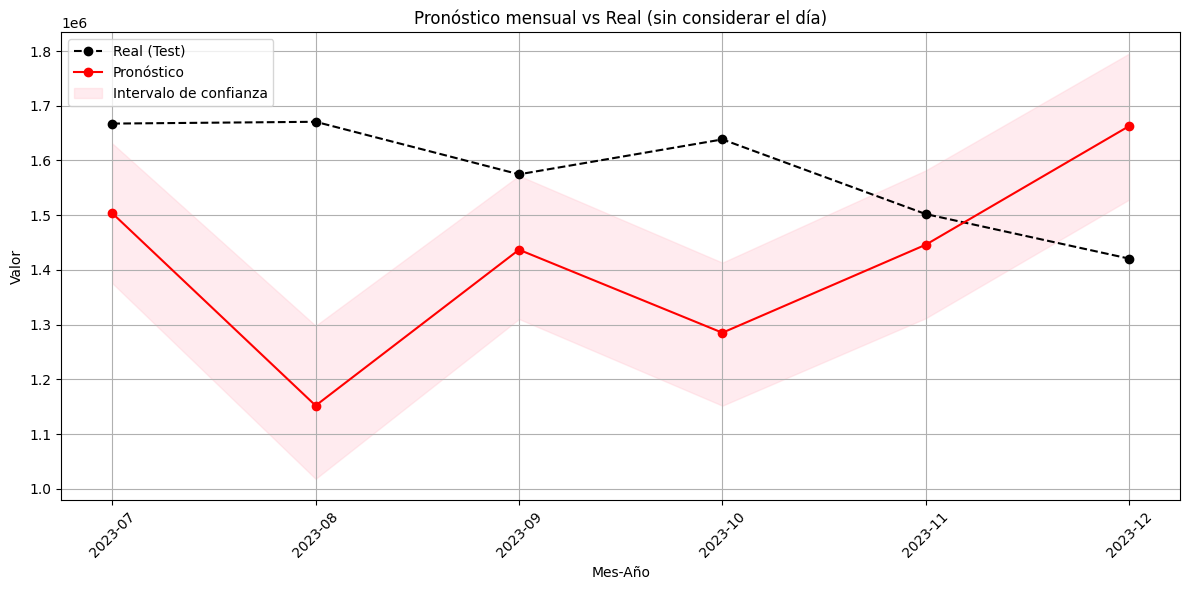

In [14]:
x_test['mes_año'] = x_test['ds'].dt.to_period('M').astype(str)
forecast['mes_año'] = forecast['ds'].dt.to_period('M').astype(str)

forecast_filtered = forecast[['mes_año', 'yhat', 'yhat_lower', 'yhat_upper']].drop_duplicates(subset='mes_año')
comparison = pd.merge(x_test[['mes_año', 'y']], forecast_filtered, on='mes_año', how='left')

plt.figure(figsize=(12, 6))
# Datos reales
plt.plot(comparison['mes_año'], comparison['y'], label='Real (Test)', color='black', linestyle='--', marker='o')
# Predicción
plt.plot(comparison['mes_año'], comparison['yhat'], label='Pronóstico', color='red', marker='o')
# Intervalos de Confianza
plt.fill_between(comparison['mes_año'], comparison['yhat_lower'], comparison['yhat_upper'], color='pink', alpha=0.3, label='Intervalo de confianza')

plt.xlabel("Mes-Año")
plt.ylabel("Valor")
plt.title("Pronóstico mensual vs Real (sin considerar el día)")
plt.xticks(rotation=45)
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()